In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_validate, KFold, GridSearchCV
from sklearn.linear_model import PoissonRegressor, LinearRegression,GammaRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_poisson_deviance
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [144]:
def prepare_data(file_path,cols = None,idx = 'FIPS',target = 'EVICTIONS'):

    df = pd.read_csv(file_path)
    df = df.sample(frac=1,random_state = 12)

    df['socio_economic'] = ((df['EP_UNEMP'] + df['EP_NOHSDP'])/2)/df['EP_PCI']
    df['vulnerable_age'] = (df['EP_AGE17']+df['EP_AGE65'])/2
    df['minrty_lang'] = (df['EP_MINRTY'] + df['EP_LIMENG'])/2
    df['pop_density'] = df['POPULATION']/df['AREA']
    
    df['FRI'] = df['CFLD_EALT'] + df['RFLD_EALT']
    df['EAL_VALT'].fillna(0,inplace=True)
    
    df['DENIED'].fillna(0,inplace=True)
    df['DENIED'] = df['DENIED']*100/df['POPULATION']

    df[['AFAM','HISPANIC','WHITE','NUM_LOANS']] = (df[['AFAM','HISPANIC','WHITE','NUM_LOANS']]\
                                          .div(df['POPULATION'],axis=0))*100

    df.dropna(inplace=True)#Inpute missing is better
    
    if cols is not None:
        df = df[cols+[idx,target]]
        
    X,y = df.drop([idx,target],axis=1),df['EVICTIONS']

    return X,y

In [145]:
cols = [
        'pop_density',
        'minrty_lang',
        'vulnerable_age',
        'socio_economic',
        'EAL_VALT',
        'MEAN_LOAN_AMOUNT',
        'AFAM',
        'WHITE',
        'POPULATION'
       ]

#cols = None

X_train, y_train = prepare_data("../data/processed/sepher_model_data/train.csv",cols = cols)
m,n = X_train.shape

X_test, y_test = prepare_data("../data/processed/sepher_model_data/test.csv",cols = cols)

In [158]:
X_train.corr()

,pop_density,minrty_lang,vulnerable_age,socio_economic,EAL_VALT,MEAN_LOAN_AMOUNT,AFAM,WHITE,POPULATION
pop_density,1.000000,0.444636,-0.150557,0.276778,-0.111321,0.266749,-0.033458,-0.258912,0.008424
minrty_lang,0.444636,1.000000,-0.159840,0.584626,-0.099029,0.077187,0.422734,-0.537583,0.033913
vulnerable_age,-0.150557,-0.159840,1.000000,-0.019780,0.060760,-0.071181,-0.043382,0.150717,-0.026178
socio_economic,0.276778,0.584626,-0.019780,1.000000,-0.076817,-0.007438,0.044456,-0.533265,-0.137259
EAL_VALT,-0.111321,-0.099029,0.060760,-0.076817,1.000000,-0.023810,-0.038203,0.102816,0.282823
MEAN_LOAN_AMOUNT,0.266749,0.077187,-0.071181,-0.007438,-0.023810,1.000000,-0.033343,-0.002499,0.018381
AFAM,-0.033458,0.422734,-0.043382,0.044456,-0.038203,-0.033343,1.000000,-0.080101,0.125469
WHITE,-0.258912,-0.537583,0.150717,-0.533265,0.102816,-0.002499,-0.080101,1.000000,0.122221
POPULATION,0.008424,0.033913,-0.026178,-0.137259,0.282823,0.018381,0.125469,0.122221,1.000000


In [146]:

temp = X_train.copy()
vifs = pd.Series([variance_inflation_factor(sm.add_constant(temp).values, i) 
               for i in range(temp.shape[1])], 
              index=temp.columns).sort_values(ascending=False)
vifs

pop_density         39.958057
vulnerable_age       2.812597
EAL_VALT             1.859074
POPULATION           1.629138
WHITE                1.457430
minrty_lang          1.456010
MEAN_LOAN_AMOUNT     1.114528
AFAM                 1.088328
socio_economic       1.061170
dtype: float64

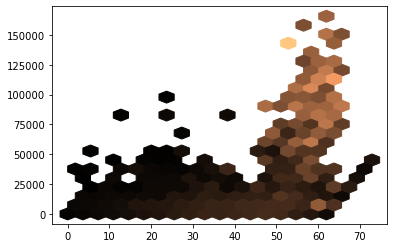

In [147]:
plt.hexbin(X_train['minrty_lang'],
           X_train['pop_density'], 
           C=y_train,
           gridsize=20,
           cmap="copper")
plt.show()

In [148]:
X_train.corr()

,pop_density,minrty_lang,vulnerable_age,socio_economic,EAL_VALT,MEAN_LOAN_AMOUNT,AFAM,WHITE,POPULATION
pop_density,1.000000,0.444636,-0.150557,0.276778,-0.111321,0.266749,-0.033458,-0.258912,0.008424
minrty_lang,0.444636,1.000000,-0.159840,0.584626,-0.099029,0.077187,0.422734,-0.537583,0.033913
vulnerable_age,-0.150557,-0.159840,1.000000,-0.019780,0.060760,-0.071181,-0.043382,0.150717,-0.026178
socio_economic,0.276778,0.584626,-0.019780,1.000000,-0.076817,-0.007438,0.044456,-0.533265,-0.137259
EAL_VALT,-0.111321,-0.099029,0.060760,-0.076817,1.000000,-0.023810,-0.038203,0.102816,0.282823
MEAN_LOAN_AMOUNT,0.266749,0.077187,-0.071181,-0.007438,-0.023810,1.000000,-0.033343,-0.002499,0.018381
AFAM,-0.033458,0.422734,-0.043382,0.044456,-0.038203,-0.033343,1.000000,-0.080101,0.125469
WHITE,-0.258912,-0.537583,0.150717,-0.533265,0.102816,-0.002499,-0.080101,1.000000,0.122221
POPULATION,0.008424,0.033913,-0.026178,-0.137259,0.282823,0.018381,0.125469,0.122221,1.000000


# Poisson Regression

In [149]:
pipe_pr = Pipeline([('scaler', StandardScaler()), ('pr', PoissonRegressor(max_iter=10000))])

In [150]:
parameters = {'pr__alpha':np.arange(0,3.1,.1)}
gcv = GridSearchCV(pipe_pr,parameters,cv=10,scoring='neg_mean_absolute_error',n_jobs=-1)
gcv.fit(X_train,y_train)
best_pipe = gcv.best_estimator_
best_pipe.fit(X_train,y_train)
best_pr = best_pipe['pr']

In [151]:
gcv.best_score_,best_pr.alpha

(-14.903876536303594, 0.0)

In [152]:
y_pred = best_pipe.predict(X_test)

In [153]:
id_outlier = np.where(y_pred==y_pred.max())[0][0]

y_test_l = list(y_test)
y_pred_l = list(y_pred)

y_test_l.pop(id_outlier)
y_pred_l.pop(id_outlier)

1104.484362499489

In [154]:
mean_absolute_error(y_test_l,y_pred_l)

14.862304209645712

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


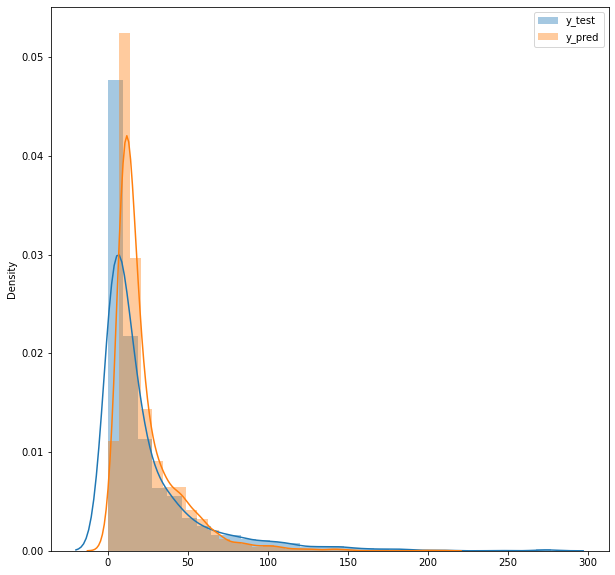

In [155]:
ax = plt.figure(figsize = (10,10))
sns.distplot(x = y_test_l,bins = 30,label = 'y_test')
sns.distplot(x = y_pred_l,bins = 30,label = 'y_pred')
plt.legend()
plt.show()

In [156]:
best_pr_coeffs = pd.DataFrame({'coefs':best_pr.coef_},index = X_train.columns)
best_pr_coeffs['coefs_abs'] = best_pr_coeffs['coefs'].abs()
best_pr_coeffs = best_pr_coeffs\
    .sort_values(by ='coefs_abs',
                 ascending=False)

In [157]:
best_pr_coeffs

,coefs,coefs_abs
WHITE,-0.446515,0.446515
POPULATION,0.278915,0.278915
minrty_lang,0.264467,0.264467
EAL_VALT,-0.174406,0.174406
AFAM,0.092020,0.092020
vulnerable_age,-0.087966,0.087966
socio_economic,0.051564,0.051564
pop_density,0.019700,0.019700
MEAN_LOAN_AMOUNT,0.001394,0.001394


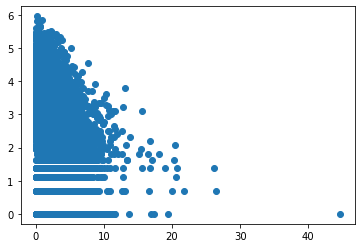

In [33]:
plt.scatter(X_train['WHITE'],np.log1p(y_train))
#plt.xlim(-1,20)

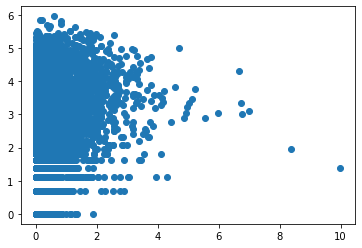

In [34]:
plt.scatter(X_train['AFAM'],np.log1p(y_train))
#plt.xlim(-1,20)

In [44]:
glm_model = sm.GLM(y_train.values,sm.add_constant(X_train),family=sm.families.Poisson())
glm_results = glm_model.fit()
glm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                10200
Model:                            GLM   Df Residuals:                    10190
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0320e+05
Date:                Thu, 25 Nov 2021   Deviance:                   1.6470e+05
Time:                        12:28:05   Pearson chi2:                 2.69e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.0896      0.013    245.097      0.000       3.065       3.114
pop_density       1.533e-06   1.19e-07     12.932      0.000     1.3e-06    1.76e-06
minrty_lang          0.0178      0.000     89.441      0.000       0.017       0.018
vulnerable_age      -0.0120      0.000    -43.257      0.000      -0.013      -0.011
socio_economic    2.993e-07   2.58e-08     11.612      0.000    2.49e-07     3.5e-07
EAL_VALT         -2.677e-07   4.13e-09    -64.825      0.000   -2.76e-07    -2.6e-07
MEAN_LOAN_AMOUNT  1.172e-06   1.97e-06      0.595      0.552   -2.69e-06    5.03e-06
AFAM                 0.1392      0.003     45.717      0.000       0.133       0.145
WHITE               -0.2225      0.002   -124.166      0.000      -0.226      -0.219
POPULATION           0.0001    8.3e-07    154.013      0.000       0.000       0.000
====================================================================================
"""

# Gamma regression

In [45]:
pipe_gr = Pipeline([('scaler', StandardScaler()), ('gr', GammaRegressor(max_iter=10000))])

In [46]:
aux_bias = 0.0001
parameters = {'gr__alpha':np.arange(0,6,0.1)}
gcv = GridSearchCV(pipe_gr,parameters,cv=10,scoring='neg_mean_absolute_error',n_jobs=-1)
gcv.fit(X_train,y_train+aux_bias) # add .1 to avoid out of distribution error
best_pipe = gcv.best_estimator_
best_pipe.fit(X_train,y_train+aux_bias)
best_gr = best_pipe['gr']

In [47]:
gcv.best_score_

-15.079676965592904

In [48]:
gcv.best_estimator_['gr'].alpha

0.6000000000000001

In [49]:
y_pred = best_pipe.predict(X_test)-aux_bias



/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


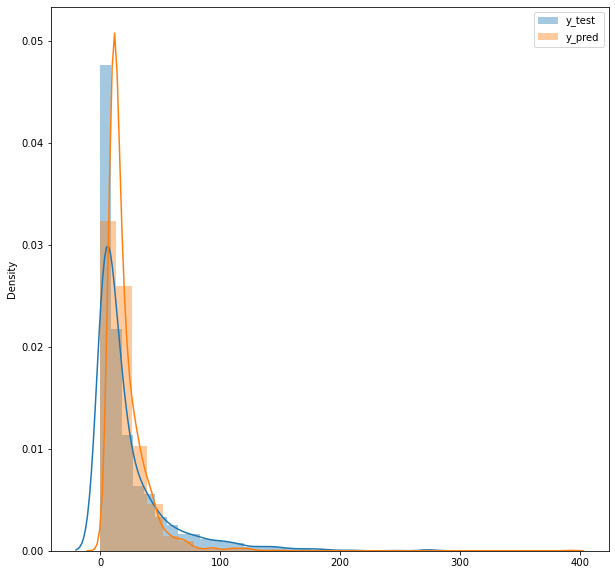

In [50]:
ax = plt.figure(figsize = (10,10))
sns.distplot(x = y_test,bins = 30,label = 'y_test')
sns.distplot(x = y_pred,bins = 30,label = 'y_pred')
plt.legend()
plt.show()

In [51]:
mean_absolute_error(y_test,y_pred)

15.15965584372183

# Random Forrest

## Loss = MSE

In [52]:
pipe_rf = Pipeline([('rf', RandomForestRegressor(n_estimators=200,
                                                n_jobs=-1,
                                                random_state = 12,
                                                criterion = 'squared_error'
                                             )
                 )
                ])

In [53]:
max_features = np.unique(np.array([n,3*n/4,n/2,n/3,n/4,np.sqrt(n)])\
                                  .round()\
                                  .astype(int))
min_samples_leaf = 2**np.arange(5)

parameters = {'rf__max_features':max_features,
              'rf__min_samples_leaf':min_samples_leaf
             }

gcv = GridSearchCV(pipe_rf,parameters,cv=10,scoring='neg_mean_absolute_error',verbose=2)
gcv.fit(X_train,y_train)
best_pipe = gcv.best_estimator_
best_pipe.fit(X_train,y_train)
best_model = best_pipe['rf']

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   1.4s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   1.3s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   1.1s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   1.4s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   1.2s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   1.1s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   1.3s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   1.3s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   1.1s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   1.6s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=2; total time=   0.9s
[CV] END .........rf__max_features=2, rf__min_

[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   1.5s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   1.5s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   1.6s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   1.8s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   1.5s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   1.5s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   1.7s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   1.6s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   1.6s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=2; total time=   1.7s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=2; total time=   1.4s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=2; total time=   1.3s
[CV] END .........rf__max_fe

[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time=   2.7s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time=   3.2s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time=   2.8s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time=   3.6s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time=   3.1s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time=   3.2s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time=   3.3s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time=   2.6s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time=   2.6s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time=   2.8s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time=   2.5s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time=   2.5s
[CV] END .........rf__max_fe

In [60]:
gcv.best_score_,best_model

(-12.174258007406742,
 RandomForestRegressor(max_features=4, min_samples_leaf=4, n_estimators=200,
                       n_jobs=-1, random_state=12))

In [61]:
y_pred = best_pipe.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


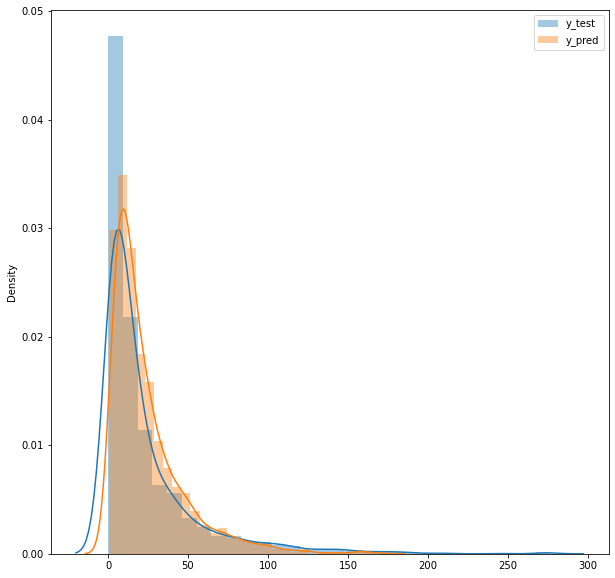

In [62]:
ax = plt.figure(figsize = (10,10))
sns.distplot(x = y_test,bins = 30,label = 'y_test')
sns.distplot(x = y_pred,bins = 30,label = 'y_pred')
plt.legend()
plt.show()

In [63]:
pd.Series(y_pred).describe()

count    2564.000000
mean       23.990973
std        23.409870
min         0.370717
25%         8.499649
50%        16.014907
75%        31.301674
max       170.830936
dtype: float64

In [64]:
pd.Series(y_test).describe()

count    2564.000000
mean       23.251950
std        32.229251
min         0.000000
25%         4.000000
50%        12.000000
75%        28.000000
max       277.000000
Name: EVICTIONS, dtype: float64

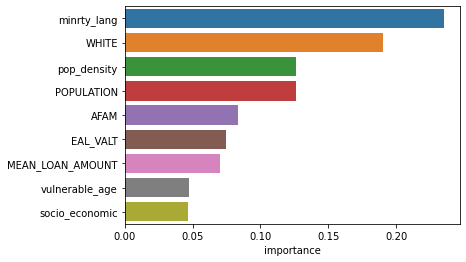

In [66]:
feature_imp = pd.DataFrame({'importance':best_model.feature_importances_},index = X_train.columns)
feature_imp = feature_imp.sort_values(by='importance',ascending=False)
sns.barplot(data = feature_imp,
            x = 'importance',
            y = feature_imp.index)
plt.show()

## Loss = Poisson

In [67]:
max_features = np.unique(np.array([n,3*n/4,n/2,n/3,n/4,np.sqrt(n)])\
                                  .round()\
                                  .astype(int))
min_samples_leaf = 2**np.arange(5)

parameters = {'rf__max_features':max_features,
              'rf__min_samples_leaf':min_samples_leaf
             }



pipe_rf_poi = Pipeline([('rf', RandomForestRegressor(n_estimators=200,
                                                n_jobs=-1,
                                                random_state = 12,
                                                criterion = 'poisson'
                                             )
                 )
                ])

parameters = {'rf__max_features':max_features,
              'rf__min_samples_leaf':min_samples_leaf
             }

gcv_rf_poi = GridSearchCV(pipe_rf_poi,parameters,cv=10,scoring='neg_mean_absolute_error',verbose=2)
gcv_rf_poi.fit(X_train,y_train)
best_pipe_rf_poi = gcv_rf_poi.best_estimator_
best_pipe_rf_poi.fit(X_train,y_train)



Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   4.4s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   3.3s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   3.4s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   3.8s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   3.2s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   3.2s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   3.2s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   3.2s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   3.3s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=   3.4s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=2; total time=   2.9s
[CV] END .........rf__max_features=2, rf__min_

[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   7.1s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   7.1s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   7.1s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   7.0s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   7.2s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   6.9s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   7.0s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   7.1s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=   7.0s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=2; total time=   6.2s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=2; total time=   6.1s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=2; total time=   6.2s
[CV] END .........rf__max_fe

[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time=  15.2s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time=  14.8s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time=  15.1s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time=  15.0s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time=  14.9s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time=  15.2s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time=  15.2s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time=  13.1s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time=  13.1s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time=  13.3s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time=  13.4s
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time=  13.2s
[CV] END .........rf__max_fe

Pipeline(steps=[('rf',
                 RandomForestRegressor(criterion='poisson', max_features=2,
                                       min_samples_leaf=8, n_estimators=200,
                                       n_jobs=-1, random_state=12))])

In [68]:
best_model_rf_poi = best_pipe_rf_poi['rf']

In [74]:
gcv_rf_poi.best_score_,best_model_rf_poi

(-14.866165156715997,
 RandomForestRegressor(criterion='poisson', max_features=2, min_samples_leaf=8,
                       n_estimators=200, n_jobs=-1, random_state=12))

In [82]:
y_pred_rf_poi = best_pipe_rf_poi.predict(X_test)

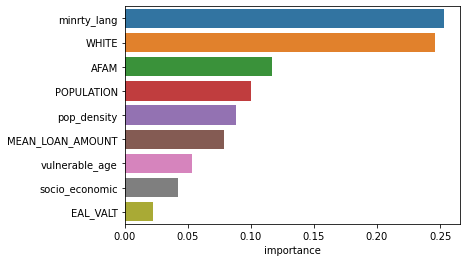

In [79]:
feature_imp = pd.DataFrame({'importance':best_model_rf_poi.feature_importances_},index = X_train.columns)
feature_imp = feature_imp.sort_values(by='importance',ascending=False)
sns.barplot(data = feature_imp,
            x = 'importance',
            y = feature_imp.index)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


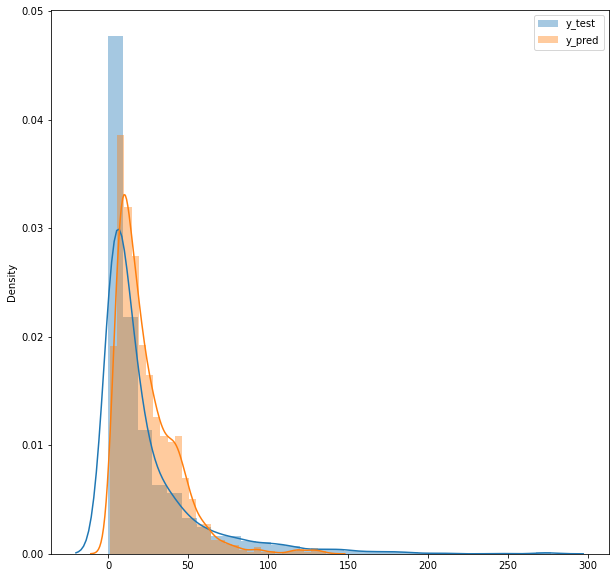

In [83]:
ax = plt.figure(figsize = (10,10))
sns.distplot(x = y_test,bins = 30,label = 'y_test')
sns.distplot(x = y_pred_rf_poi,bins = 30,label = 'y_pred')
plt.legend()
plt.show()

## Loss = MAE

In [87]:
pipe_rf_mae = Pipeline([('rf', RandomForestRegressor(n_estimators=200,
                                                n_jobs=-1,
                                                random_state = 12,
                                                criterion = 'absolute_error'
                                             )
                 )
                ])

In [88]:
max_features = np.unique(np.array([n,3*n/4,n/2,n/3,n/4,np.sqrt(n)])\
                                  .round()\
                                  .astype(int))
min_samples_leaf = 2**np.arange(5)

parameters = {'rf__max_features':max_features,
              'rf__min_samples_leaf':min_samples_leaf
             }



gcv_rf_mae = GridSearchCV(pipe_rf_mae,parameters,cv=10,scoring='neg_mean_absolute_error',verbose=2)
gcv_rf_mae.fit(X_train,y_train)
best_pipe_rf_mae = gcv_rf_mae.best_estimator_
best_pipe_rf_mae.fit(X_train,y_train)


Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=  27.1s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=  29.7s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=  27.8s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=  31.0s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=  30.3s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=  29.2s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=  33.5s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=  30.5s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=  30.1s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=1; total time=  34.6s
[CV] END .........rf__max_features=2, rf__min_samples_leaf=2; total time=  29.6s
[CV] END .........rf__max_features=2, rf__min_

[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  46.6s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  48.1s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  46.2s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  46.8s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  54.3s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  47.7s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  51.2s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  52.1s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=1; total time=  55.7s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=2; total time=  49.9s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=2; total time=  46.9s
[CV] END .........rf__max_features=4, rf__min_samples_leaf=2; total time=  53.5s
[CV] END .........rf__max_fe

[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time= 1.6min
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time= 1.5min
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time= 1.5min
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time= 1.5min
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time= 1.6min
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time= 1.6min
[CV] END .........rf__max_features=9, rf__min_samples_leaf=1; total time= 1.6min
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time= 1.5min
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time= 1.5min
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time= 1.5min
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time= 1.5min
[CV] END .........rf__max_features=9, rf__min_samples_leaf=2; total time= 1.5min
[CV] END .........rf__max_fe

Pipeline(steps=[('rf',
                 RandomForestRegressor(criterion='absolute_error',
                                       max_features=4, min_samples_leaf=8,
                                       n_estimators=200, n_jobs=-1,
                                       random_state=12))])

In [89]:
best_model_rf_mae = best_pipe_rf_mae['rf']

In [90]:
gcv_rf_mae.best_score_,best_model_rf_mae

(-11.666384068627451,
 RandomForestRegressor(criterion='absolute_error', max_features=4,
                       min_samples_leaf=8, n_estimators=200, n_jobs=-1,
                       random_state=12))

In [91]:
y_pred_rf_mae = best_model_rf_mae.predict(X_test)

In [104]:
mean_absolute_error(y_test,y_pred_rf_mae)

12.315132605304212

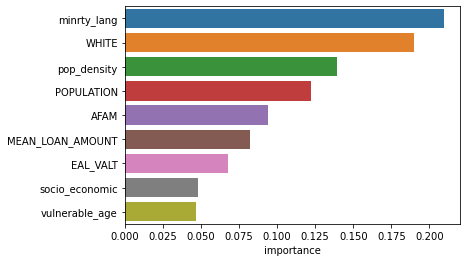

In [92]:
feature_imp = pd.DataFrame({'importance':best_model_rf_mae.feature_importances_},index = X_train.columns)
feature_imp = feature_imp.sort_values(by='importance',ascending=False)
sns.barplot(data = feature_imp,
            x = 'importance',
            y = feature_imp.index)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


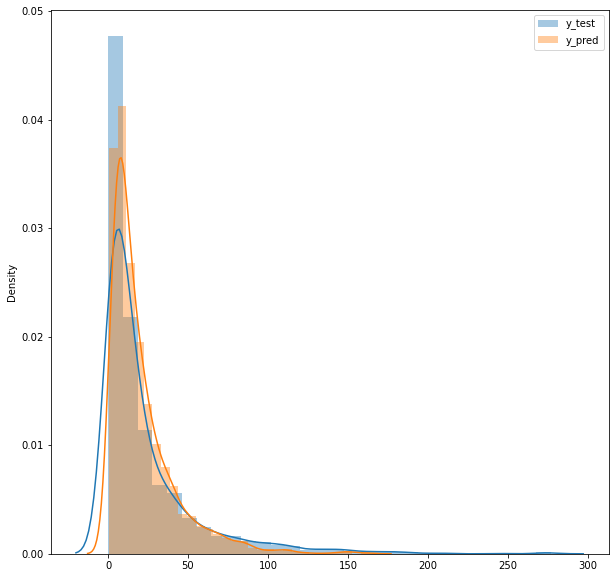

In [93]:
ax = plt.figure(figsize = (10,10))
sns.distplot(x = y_test,bins = 30,label = 'y_test')
sns.distplot(x = y_pred_rf_mae,bins = 30,label = 'y_pred')
plt.legend()
plt.show()

In [102]:
from sklearn.inspection import permutation_importance
r = permutation_importance(best_model_rf_mae, X_test, y_test,
                           n_repeats=100,
                           random_state=0,scoring='neg_mean_absolute_error')

In [103]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{X_train.columns[i]:<8}"
               f" {r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

WHITE    3.616 +/- 0.184
POPULATION 1.981 +/- 0.139
minrty_lang 1.566 +/- 0.119
pop_density 1.538 +/- 0.124
MEAN_LOAN_AMOUNT 0.907 +/- 0.060
AFAM     0.637 +/- 0.093
EAL_VALT 0.525 +/- 0.056
socio_economic 0.272 +/- 0.031
vulnerable_age 0.178 +/- 0.034
